# Laboratorio 6
- Mark Albrand 21004
- Jimena Hernández 21199

## IA Generativa

Para este laboratorio se deberá acudir al uso de un modelo de IAGen para que funcione de guía en el desarrollo del laboratorio. El modelo elegido es ChatGPT4, el cual es un modelo de lenguaje natural que se puede utilizar para generar texto.

### Rol de la IA Generativa

**Asistente**

```text
Sirva como Copiloto de Análisis de Datos para navegar mi proyecto de análisis de datos que consiste en la implementación y entrenamiento de una GAN en un conjunto de datos consta de más de 200,000 imágenes a color, de 128 X 128 X 3 c/u.

Responsabilidades:

1. Colaborar: Comprenda los datos que influyen en nuestro análisis.
2. Integrar: Utilice el archivo CSV proporcionado en nuestro espacio de trabajo para las discusiones.
3. Dialogar: Participe en una interacción bidireccional, haciendo pausas para mi aportación.
4. Revisar: Evalúe conjuntamente los resultados, considerando mejoras y proporcione consejos de mejora.
5. Confirmar: Repita mis directivas para asegurar la sincronización.

Entorno de trabajo: Jupyter Notebook.

Repita mis objetivos para confirmar la alineación.
```

*Respuesta:*

```text
Para asegurarnos de estar alineados en tu proyecto de análisis de datos utilizando GANs, aquí están los objetivos que mencionaste:

Colaborar: Trabajaré contigo para entender y analizar los datos que influyen en nuestro proyecto, que consiste en más de 200,000 imágenes a color de 128 x 128 x 3.
Integrar: Utilizaré el archivo CSV que has proporcionado para incorporarlo a nuestro espacio de trabajo y discutir los datos relevantes.
Dialogar: Mantendré una comunicación activa y bidireccional, haciendo pausas para recibir tus aportes y discutir los avances.
Revisar: Evaluaremos juntos los resultados obtenidos del entrenamiento de la GAN, considerando posibles mejoras y ajustes según sea necesario.
Confirmar: Repetiré tus instrucciones para asegurar que estamos en sincronía con los pasos a seguir y los objetivos del proyecto.
Trabajaremos en un entorno de Jupyter Notebook. ¿Todo esto refleja correctamente tus expectativas para proceder?
```

### Exploración de datos

- img_align_celeba.zip: Todas las imágenes de rostros, recortadas y alineadas.
- list_eval_partition.csv: Particionado recomendado de las imágenes en conjuntos de entrenamiento, validación y prueba. Las imágenes 1-162770 son para entrenamiento, 162771-182637 para validación y 182638-202599 para prueba.
- list_bbox_celeba.csv: Información de los cuadros delimitadores para cada imagen. "x_1" y "y_1" representan las coordenadas del punto superior izquierdo del cuadro delimitador. "width" (ancho) y "height" (altura) representan el ancho y la altura del cuadro delimitador.
- list_landmarks_align_celeba.csv: Hitos de imagen y sus respectivas coordenadas. Hay 5 hitos: ojo izquierdo, ojo derecho, nariz, boca izquierda, boca derecha.
- list_attr_celeba.csv: Etiquetas de atributos para cada imagen. Hay 40 atributos. "1" representa positivo mientras que "-1" representa negativo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# cargar el conjunto de datos CelebA de la carpeta 'archive'
celeb_attributes = pd.read_csv('archive/list_attr_celeba.csv')

# mostrar las primeras 5 filas del conjunto de datos
print(celeb_attributes.head())

     image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  We

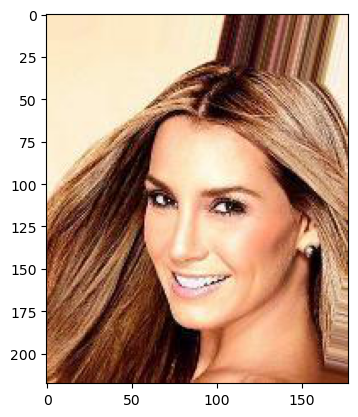

In [3]:
# mostrar imagen de ejemplo
img = plt.imread('archive/img_align_celeba/img_align_celeba/000001.jpg')
plt.imshow(img)

In [4]:
celeb_bbox = pd.read_csv('archive/list_bbox_celeba.csv')
celeb_bbox.head()

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166


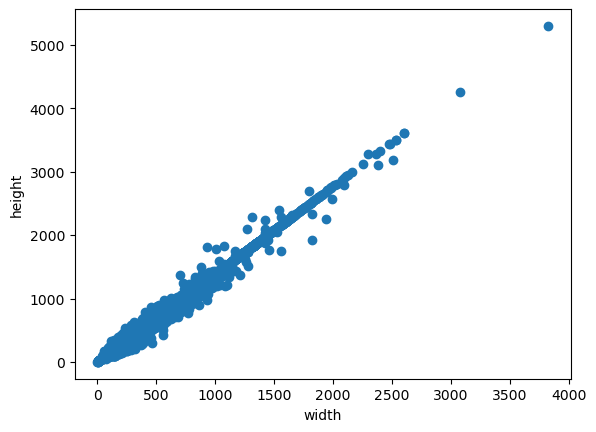

In [5]:
# plot bounding box widht and height
plt.figure()
plt.scatter(celeb_bbox['width'], celeb_bbox['height'])
plt.xlabel('width')
plt.ylabel('height')
plt.show()

### 1. Recorte, Redimensionamiento y Normalización de imágenes

Respuesta : 
Dado que tienes las coordenadas del cuadro delimitador para cada imagen, puedes usar estas para recortar las caras de las imágenes. Esto ayudará a la GAN a enfocarse únicamente en las características faciales, mejorando la calidad de la generación.

In [6]:
from PIL import Image

def crop_image(image_path, bbox):
    image = Image.open(image_path)
    x, y, width, height = bbox
    cropped_image = image.crop((x, y, x + width, y + height))
    return cropped_image

def resize_image(cropped_image, size=(64, 64)):
    resized_image = cropped_image.resize(size, Image.ANTIALIAS)
    return resized_image

def normalize_image(resized_image):
    np_image = np.array(resized_image)
    normalized_image = (np_image - 127.5) / 127.5  # Normalizar a [-1, 1]
    return normalized_image


In [7]:
# generar particiones de entrenamiento, prueba y validación en base a list_eval_partition.csv
celeb_partition = pd.read_csv('archive/list_eval_partition.csv')

celeb_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [8]:
X_train = celeb_partition[celeb_partition['partition'] == 0]["image_id"].values
X_val = celeb_partition[celeb_partition['partition'] == 1]["image_id"].values
X_test = celeb_partition[celeb_partition['partition'] == 2]["image_id"].values

print('Número de imágenes de entrenamiento:', len(X_train))
print('Número de imágenes de validación:', len(X_val))
print('Número de imágenes de prueba:', len(X_test))

Número de imágenes de entrenamiento: 162770
Número de imágenes de validación: 19867
Número de imágenes de prueba: 19962


In [9]:
def load_and_preprocess_image(image_path, target_size=(64, 64)): 
    """Load and preprocess an image."""
    image = Image.open(image_path).convert('RGB')   # Open the image and convert it to RGB format
    image = image.resize(target_size, Image.LANCZOS) # Resize the image to the target size using Lanczos resampling
    image_array = np.asarray(image, dtype=np.float32) # Convert the image to a numpy array of type float32
    image_array = (image_array - 127.5) / 127.5  # Normalize pixel values to the range [-1, 1] for better 
 
    return image_array # this will return 

In [10]:
X_train_images = []
X_val_images = []
X_test_images = []

for i in X_train:
    image_path = f'archive/img_align_celeba/img_align_celeba/{i}'
    image = load_and_preprocess_image(image_path)
    X_train_images.append(image)

for i in X_val:
    image_path = f'archive/img_align_celeba/img_align_celeba/{i}'
    image = load_and_preprocess_image(image_path)
    X_val_images.append(image)

for i in X_test:
    image_path = f'archive/img_align_celeba/img_align_celeba/{i}'
    image = load_and_preprocess_image(image_path)
    X_test_images.append(image)

In [11]:
print(X_train_images[0].shape)
print(X_val_images[0].shape)
print(X_test_images[0].shape)

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


### Implementación de la GAN

```puedes explicarme a detalle como puedo implementar el modelo de la GAN?```

*Respuesta:*
En Keras, definirás modelos secuenciales para el generador y el discriminador. Usualmente, el generador intenta engañar al discriminador generando imágenes que parezcan reales a partir de un ruido aleatorio.

```from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, LeakyReLU, BatchNormalization
from keras.optimizers import Adam
import numpy as np

# Definir el generador
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod((128, 128, 3)), activation='tanh'))
    model.add(Reshape((128, 128, 3)))
    return model

# Definir el discriminador
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(128, 128, 3)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model
```

In [20]:
IMG_SHAPE = (64, 64, 3)  # Target shape for images
NUM_IMAGES = 10000  # Number of images to load
BATCH_SIZE = 32  # Batch size for training

In [21]:
from tensorflow.keras import layers
import tensorflow as tf

def build_generator():
    model = tf.keras.Sequential()  
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))  
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU())  
    model.add(layers.Reshape((8, 8, 256)))  

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))  
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU())  
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))

    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU()) 

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) 
    return model

def build_discriminator():
    """Build the discriminator model."""
    model = tf.keras.Sequential()  # Initialize a sequential model
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=IMG_SHAPE))  # First convolutional layer with 64 filters, 5x5 kernel, stride of 2, and same padding
    model.add(layers.LeakyReLU())  # LeakyReLU activation layer
    model.add(layers.Dropout(0.3))  # Dropout layer with a dropout rate of 0.3

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))  # Second convolutional layer with 128 filters, 5x5 kernel, stride of 2, and same padding
    model.add(layers.LeakyReLU())  # LeakyReLU activation layer
    model.add(layers.Dropout(0.3))  # Dropout layer with a dropout rate of 0.3

    model.add(layers.Flatten())  # Flatten the output to prepare for the dense layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Dense layer with a single output and sigmoid activation (for binary classification)
    return model  # Return the discriminator model

# Instantiate GAN components
generator = build_generator()  # Instantiate the generator model
discriminator = build_discriminator()  # Instantiate the discriminator model

c:\Users\marka\anaconda3\envs\DataMining11\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
discriminator.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,561 (947.50 KB)

 Trainable params: 242,561 (947.50 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
generator.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 16384)          │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 32, 32, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 64, 64, 3)      │         4,800 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,733,504 (10.43 MB)

 Trainable params: 2,700,352 (10.30 MB)

 Non-trainable params: 33,152 (129.50 KB)

### Entrenamiento de la GAN

In [24]:
# Define the loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) 
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


c:\Users\marka\anaconda3\envs\DataMining11\Lib\site-packages\keras\src\backend\tensorflow\nn.py:695: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


--------------------------------------------------
Epoch 1, Generator Loss: 1.2442816495895386, Discriminator Loss: 0.7550970315933228
Time for epoch 1 is 575.434648513794 sec
--------------------------------------------------
Epoch 2, Generator Loss: 1.2143752574920654, Discriminator Loss: 1.2731775045394897
Time for epoch 2 is 520.5093734264374 sec


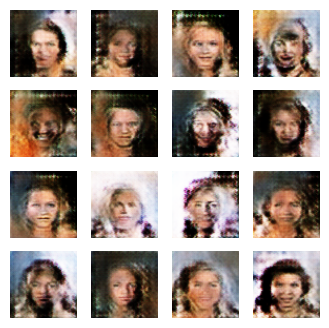

In [25]:
import matplotlib.pyplot as plt
import time

# Lists to store generator and discriminator losses
gen_loss = []
disc_loss = []

# Dimensionality of the noise vector (latent space)
noise_dim = 100

# Training step function
@tf.function
def train_step(real_images):
    """Performs a single training step for both the generator and discriminator."""
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  # Generate random noise for the generator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)  # Generate images from the noise
        real_output = discriminator(real_images, training=True)  # Get discriminator output for real images
        fake_output = discriminator(generated_images, training=True)  # Get discriminator output for fake images

        # Calculate generator loss
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        # Calculate discriminator loss
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

    # Compute gradients for the generator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute gradients for the discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the gradients to the generator
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    # Apply the gradients to the discriminator
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss  # Return the generator and discriminator losses

def generate_and_save_images(model, epoch, noise_dim):
    """Generates and saves images from the generator model."""
    noise = tf.random.normal([16, noise_dim])  # Generate random noise
    predictions = model(noise, training=False)  # Generate images from the noise
    
    fig = plt.figure(figsize=(4, 4))  # Create a figure to display the images

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)  # Add a subplot for each generated image
        plt.imshow((predictions[i] * 127.5 + 127.5).numpy().astype('uint8'))  # Rescale the image values to [0, 255]
        plt.axis('off')  # Turn off the axis

    plt.show()  # Display the images

def train(dataset, epochs):
    """Trains the GAN for a specified number of epochs."""
    for epoch in range(epochs):
        start = time.time()  # Record the start time of the epoch

        for image_batch in dataset:
            gen_loss_value, disc_loss_value = train_step(image_batch)  # Perform a training step
            gen_loss.append(gen_loss_value.numpy())  # Append generator loss to the list
            disc_loss.append(disc_loss_value.numpy())  # Append discriminator loss to the list

        # Print the losses and time taken for the epoch
        print('-' * 50)  # Separator line
        print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss_value}, Discriminator Loss: {disc_loss_value}')
        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')
                # Generate and save images every 5 epochs
        if (epoch + 1) % 2 == 0:
            generate_and_save_images(generator, epoch + 1, noise_dim)

with tf.device('/gpu:0'):
    # Create a TensorFlow dataset from the images, shuffle, and batch them
    train_dataset = tf.data.Dataset.from_tensor_slices(X_train_images).shuffle(60000).batch(BATCH_SIZE)

    # Train the GAN for a specified number of epochs
    train(train_dataset, epochs=2)

### Reflexión sobre el uso de un modelo de IAGen y el laboratorio (5 puntos)